In [ ]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [2]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

## Agent 만들기

In [4]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict): # 그래프의 상태를 정의하는 클래스
    messages: Annotated[list, add_messages] # 메시지 누적

graph_builder = StateGraph(State) # StateGraph 생성 (대화 흐름 관리)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [6]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
        A node that runs the tools requested in the last AIMessage.
        마지막 AIMessage에서 요청된 도구를 실행하는 노드
    """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # ["tavily_search_results_json" : TavilySearchResults()]

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1] # 마지막 message
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls: # 메시지에서 호출된 도구를 불러옴
            tool_result = self.tools_by_name[tool_call["name"]].invoke( # Tool 호출 실행
                tool_call["args"]
            )
            outputs.append( # Tool 호출 결과(ToolMessage) 추가
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [7]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0: # if the last message has "tool_calls"
        return "tools"
    return END

# 조건부 엣지 연결
graph_builder.add_conditional_edges(
    "chatbot", # 시작 노드
    route_tools,
    {"tools": "tools", END: END}, # 반환값이 "tools" 면 "tools" 노드로, END 면 END로 이동
)

In [8]:
# 엣지 연결
graph_builder.add_edge("tools", "chatbot") # 도구가 호출될 때마다 챗봇으로 돌아가 다음 단계를 결정
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

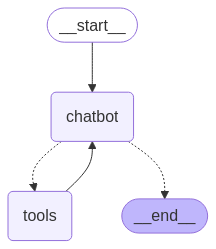

### Invoke

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}): # graph 노드 호출 결과 받아옴
        for value in event.values():
            print("Assistant:", value["messages"][-1].content) # AI 답변 출력

In [11]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: 
Assistant: [{"title": "\ub798\ud504 - \ud50c\ub808\uc774\uc5b4 \uc804\uc801 :: \uc774\ud130\ub110 \ub9ac\ud134 \ub2e5\uc9c0\uc9c0", "url": "https://dak.gg/er/players/%EB%9E%98%ED%94%84?season=PRE_SEASON_10&gameMode=RANK&character=Emma", "content": "\ub7ad\ud06c\uc2e4\ud5d8\uccb4 \ud1b5\uacc4 ; \uc544\ub514\ub098. 37 \uac8c\uc784. 24.3%. up-arrow 2747 ; \uc5e0\ub9c8. 25 \uac8c\uc784. 16.0%. up-arrow 890 ; \ube44\uc559\uce74. 14 \uac8c\uc784. 21.4%. up-arrow 410 ; \ub9ac \ub2e4\uc774\ub9b0. 11 \uac8c\uc784. 18.2%. up-", "score": 0.22740968}, {"title": "[\uadf8\ub798\ud504\uc640 \ucd94\ucc9c \uc2dc\uc2a4\ud15c] \ud398\uc774\uc9c0 \ub7ad\ud06c - \uc790\uc730\uc774\uc758 \uc131\uc7a5\uc77c\uae30", "url": "https://think-tech.tistory.com/48", "content": "\ud398\uc774\uc9c0 \ub7ad\ud06c(Page Rank)\ub780? \uc6f9\uc740 \uc6f9 \ud398\uc774\uc9c0\uc640 \ud558\uc774\ud37c\ub9c1\ud06c\ub85c \uad6c\uc131\ub41c \ubc29\ud5a5\uc131\uc774 \uc788\u

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass